# Inference

In [1]:
%%capture
!pip install timm

In [2]:
# Torch
import torchvision.transforms as TT
# import torchvision
import torch
from torch import nn

# Custom decorators
# from transformers import TrainingArguments, Trainer, TrainerCallback

# # Metrics(network_swinir in root dir)
from network_swinir import SwinIR
# from util_calculate_psnr_ssim import calculate_psnr, calculate_ssim

# Service imports
import os

# Plotting, reading, etc.
from PIL import Image
import matplotlib.pyplot as plt
from termcolor import colored

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Initializing pretrained model

In [3]:
class ProjectionLayer(torch.nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        self.alpha = nn.Parameter(torch.randn(1), requires_grad=True)
        self.Nt = torch.prod(torch.tensor(self.img_size))
        

    def calculate_eps(self, sigma):
        return torch.exp(self.alpha) * sigma * torch.sqrt(self.Nt - 1)

    def forward(self, pred, inp, sigma):

        eps = self.calculate_eps(sigma)

        d = pred - inp
        
        denom = torch.max(torch.linalg.norm(d, dim=(1, 2, 3)), eps)

        nom = torch.mul(eps, d.transpose(3, 0))

        p = inp + torch.div(nom, denom).transpose(3, 0)
        return p


class SwinIRP(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.swin_ir = SwinIR(**kwargs)
        img_size = (*kwargs['img_size'], 3)
        self.pj_layer = ProjectionLayer(img_size)

    def forward(self, x, sigma):
        x_ = self.swin_ir.forward(x)
        x_ = self.pj_layer(x_, x, sigma)
        return x_

    def load_swin_model(self, checkpoint):
      print(colored('checkpoint:', 'grey', attrs=['bold']), checkpoint)
      state_dict = torch.load(os.path.join(checkpoint, 'pytorch_model.bin'), map_location="cpu")
      load_result = self.swin_ir.load_state_dict(state_dict, strict=False)
      print(load_result)

In [4]:
upscale = 8
window_size = 8
height = (512 // upscale // window_size + 1) * window_size
width = (512 // upscale // window_size + 1) * window_size

In [13]:
from typing import Tuple
from tqdm.notebook import tqdm 


def valid_shape(img_size, model_img_shape):
    assert img_size[0] >= model_img_shape[0], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'
    assert img_size[0] >= model_img_shape[1], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'
    assert img_size[1] >= model_img_shape[0], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'
    assert img_size[1] >= model_img_shape[1], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'

def predict_on_image(img: Image.Image, model, model_img_shape: Tuple[int], steps: Tuple[int], sigma=None, device = 'cpu') -> Image.Image:

    model.to(device)
    model.eval()
    valid_shape(img.size, model_img_shape)

    to_tensor = TT.ToTensor()
    img = to_tensor(img).to(device) # size now: c h w
    img = torch.unsqueeze(img, dim=0) # size now: b(=1) c h w

    total_output = torch.zeros_like(img).float().to(device)
    num_predicts = torch.zeros_like(img).float().to(device)

    step_h, step_w = steps
    for start_h in tqdm(range(0, img.shape[2], step_h)):
        for start_w in range(0, img.shape[3], step_w):
            end_h = start_h + model_img_shape[0]
            end_w = start_w + model_img_shape[1]

            if end_h > img.shape[2]:
                start_h = img.shape[2] - model_img_shape[0]
                end_h = img.shape[2]

            if end_w > img.shape[3]:
                start_w = img.shape[3] - model_img_shape[1]
                end_w = img.shape[3]

            input = img[:, :, start_h : end_h, start_w : end_w]

            with torch.no_grad():
                if sigma is None:
                    total_output[:, :, start_h : end_h, start_w : end_w] += model(input)    
                else:
                    total_output[:, :, start_h : end_h, start_w : end_w] += model(input, sigma)
                num_predicts[:, :, start_h : end_h, start_w : end_w] += 1

    image_out = total_output / num_predicts
    image_out = Image.fromarray((image_out[0].cpu().detach().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

    return image_out

In [11]:
class ImageNoiseAdditor(object):
    def __init__(self, train_params, valid_params):
        '''
        train_params = dict(sigma_from: int [from 0 to 255], 
                            sigma_to: int [from 0 to 255])

        valid_params = dict(sigma: int(from 0 to 255))
        '''
        self.train_params = train_params
        self.valid_params = valid_params


    def apply(self, image, train=True):

        assert isinstance(image, Image.Image), colored(f'wrong type of image (wait {Image.Image})', 'red') + f' Got:{type(image)}'
        img_numpy = np.asarray(image).astype(float)
        
        if train:
            sigma = np.random.randint(low=self.train_params['sigma_from'], 
                                      high=self.train_params['sigma_to'])
        else:
            sigma = self.valid_params['sigma']
        
        n = np.random.randn(*img_numpy.shape)
        img_numpy += float(sigma) * n
        img_numpy = np.clip(img_numpy, 0, 255).astype(np.uint8)

        image_with_noise = Image.fromarray(img_numpy, mode='RGB')

        return image_with_noise, sigma

## Loading pretrained models

In [5]:
def load_model(checkpoint, model):
    print(colored('checkpoint:', 'grey', attrs=['bold']), checkpoint)

    state_dict = torch.load(os.path.join(checkpoint, 'pytorch_model.bin'), map_location="cpu")
    load_result = model.load_state_dict(state_dict, strict=False)

    print(load_result)

    return model

## Original SwinIR:

In [6]:
model = SwinIR(upscale=1, img_size=(height, width),
                window_size=window_size, img_range=1.,
                depths=[6, 6, 6, 6], embed_dim=120, num_heads=[6, 6, 6, 6], 
                mlp_ratio=4, upsampler=None, resi_connection='3conv')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
checkpoint_dir_path = 'checkpoint-1220'

In [9]:
checkpoint = os.path.join('checkpoints', 'original', checkpoint_dir_path)
model = load_model(checkpoint, model)

checkpoint: checkpoints/original/checkpoint-1220
<All keys matched successfully>


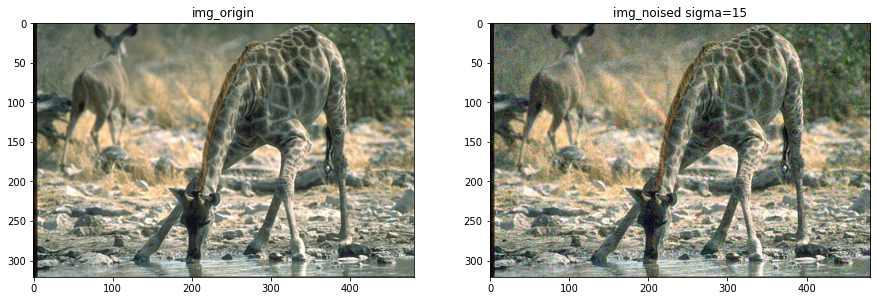

In [14]:
noiser = ImageNoiseAdditor(train_params=dict(sigma_from=10, sigma_to=55),
                           valid_params=dict(sigma=15))

img_origin = Image.open('images/giraffe.jpg')
img_noised, _ = noiser.apply(img_origin, train=False)

# img_origin = img_origin.crop((0, 0, height, width))
# img_noised = img_noised.crop((0, 0, height, width))

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(img_origin)
axs[0].set_title('img_origin')

axs[1].imshow(img_noised)
axs[1].set_title(f'img_noised sigma={15}')

plt.show()

In [16]:
img_out = predict_on_image(img_noised, model, (height, width), steps=(50, 50))

  0%|          | 0/7 [00:00<?, ?it/s]

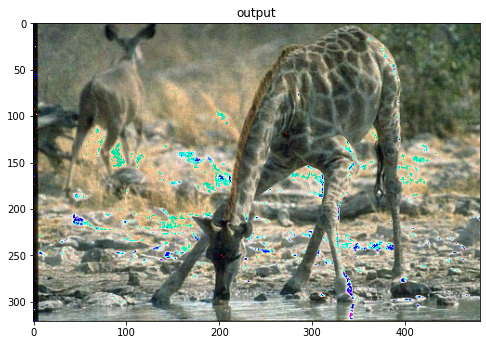

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(img_out)
plt.title('output')
plt.show()

In [18]:
img_out.save(checkpoint + '/ex_output_sigma15.png')
img_origin.save(checkpoint + '/ex_origin_sigma15.png')
img_noised.save(checkpoint + '/ex_noised_sigma15.png')

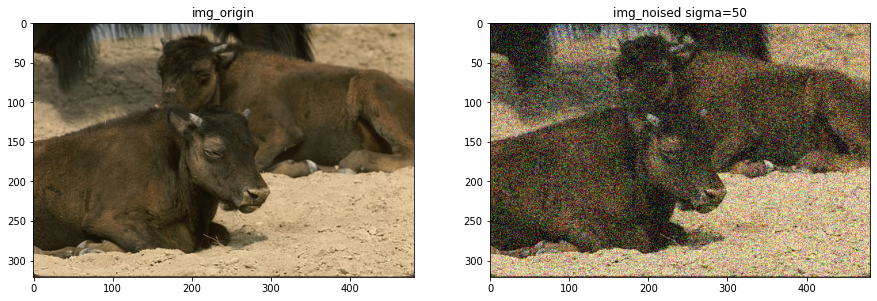

In [19]:
noiser = ImageNoiseAdditor(train_params=dict(sigma_from=10, sigma_to=55),
                           valid_params=dict(sigma=50))

img_origin = Image.open('images/bulls.jpg')
img_noised, _ = noiser.apply(img_origin, train=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(img_origin)
axs[0].set_title('img_origin')

axs[1].imshow(img_noised)
axs[1].set_title(f'img_noised sigma={50}')

plt.show()

In [20]:
img_out = predict_on_image(img_noised, model, (height, width), steps=(50, 50))

  0%|          | 0/7 [00:00<?, ?it/s]

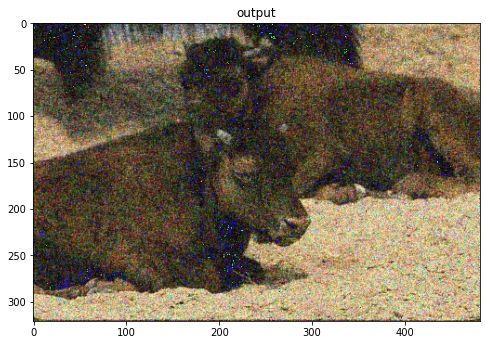

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(img_out)
plt.title('output')
plt.show()

In [22]:
img_out.save(checkpoint + '/ex_output_sigma50.png')
img_origin.save(checkpoint + '/ex_origin_sigma50.png')
img_noised.save(checkpoint + '/ex_noised_sigma50.png')

## SwinIR with projection layer:

In [23]:
model = SwinIRP(upscale=1, img_size=(height, width),
                window_size=window_size, img_range=1.,
                depths=[6, 6, 6, 6], embed_dim=120, num_heads=[6, 6, 6, 6], 
                mlp_ratio=4, upsampler=None, resi_connection='3conv')

In [24]:
checkpoint_dir_path = 'checkpoint-435'

In [25]:
checkpoint = os.path.join('checkpoints', 'projection_layer', checkpoint_dir_path)
model = load_model(checkpoint, model)

checkpoint: checkpoints/projection_layer/checkpoint-435
<All keys matched successfully>


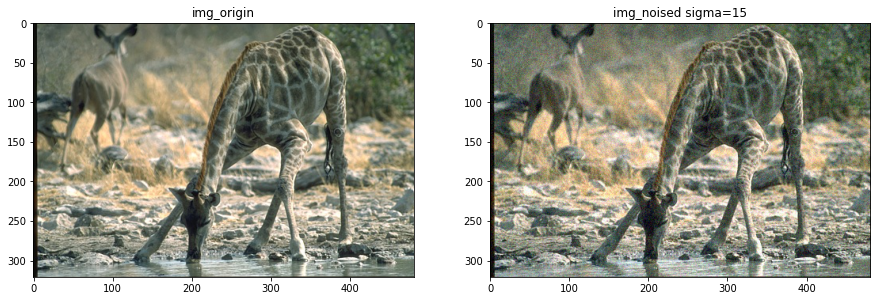

In [26]:
noiser = ImageNoiseAdditor(train_params=dict(sigma_from=10, sigma_to=55),
                           valid_params=dict(sigma=15))

img_origin = Image.open('images/giraffe.jpg')
img_noised, _ = noiser.apply(img_origin, train=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(img_origin)
axs[0].set_title('img_origin')

axs[1].imshow(img_noised)
axs[1].set_title(f'img_noised sigma={15}')

plt.show()

In [27]:
img_out = predict_on_image(img_noised, model, (height, width), steps=(50, 50), sigma=15)

  0%|          | 0/7 [00:00<?, ?it/s]

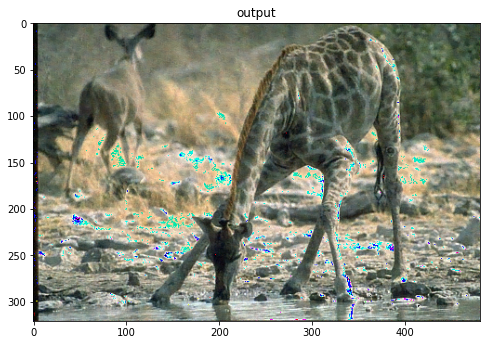

In [28]:
plt.figure(figsize=(8, 8))
plt.imshow(img_out)
plt.title('output')
plt.show()

In [29]:
img_out.save(checkpoint + '/ex_output_sigma15.png')
img_origin.save(checkpoint + '/ex_origin_sigma15.png')
img_noised.save(checkpoint + '/ex_noised_sigma15.png')

In [ ]:
noiser = ImageNoiseAdditor(train_params=dict(sigma_from=10, sigma_to=55),
                           valid_params=dict(sigma=50))

img_origin = Image.open('images/bulls.jpg')
img_noised, _ = noiser.apply(img_origin, train=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(img_origin)
axs[0].set_title('img_origin')

axs[1].imshow(img_noised)
axs[1].set_title(f'img_noised sigma={50}')

plt.show()

In [ ]:
img_out = predict_on_image(img_noised, model, (height, width), steps=(50, 50), sigma=50)

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img_out)
plt.title('output')
plt.show()

In [ ]:
img_out.save(checkpoint + '/ex_output_sigma50.png')
img_origin.save(checkpoint + '/ex_origin_sigma50.png')
img_noised.save(checkpoint + '/ex_noised_sigma50.png')